## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [8]:
import numpy as np
from matplotlib import pyplot as plt

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time, showing all 3 difficulty conditions in a single graph.
 
 

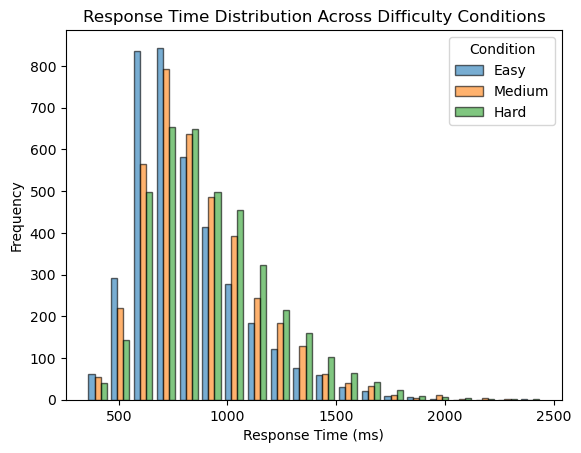

In [8]:
import pandas as pd
data= pd.read_csv ('ResponseTimeData.csv')

easy = data.loc[data['Condition'] == 'Easy', 'ResponseTime']
medium = data.loc[data['Condition'] == 'Medium', 'ResponseTime']
hard = data.loc[data['Condition'] == 'Hard', 'ResponseTime']
plt.hist([easy, medium, hard], bins=20, alpha=0.6, 
         label=['Easy', 'Medium', 'Hard'], edgecolor='black')


plt.xlabel('Response Time (ms)')
plt.ylabel('Frequency')
plt.title(f'Response Time Distribution Across Difficulty Conditions')
plt.legend(title='Condition')
plt.show()


b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

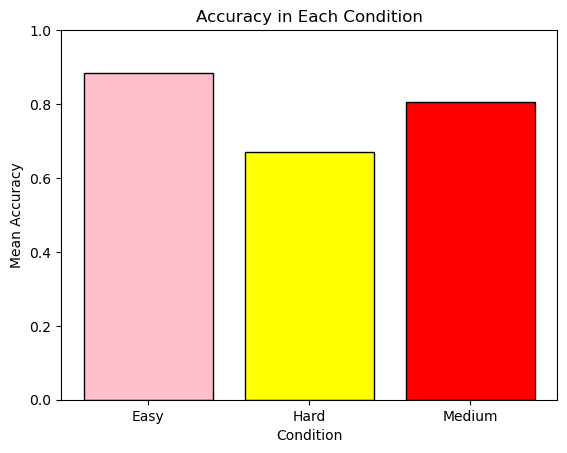

In [11]:
accuracy_by_condition= data.groupby('Condition')['Correct'].mean()
plt.bar(accuracy_by_condition.index, accuracy_by_condition.values,
        color=['pink', 'yellow', 'red'], edgecolor='black')
plt.xlabel('Condition')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy in Each Condition')
plt.ylim(0,1)
plt.show()

c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

/var/folders/sk/__601wvn5qzfk5yr32pmtd1m0000gn/T/ipykernel_95062/1842830407.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)


<function matplotlib.pyplot.show(close=None, block=None)>

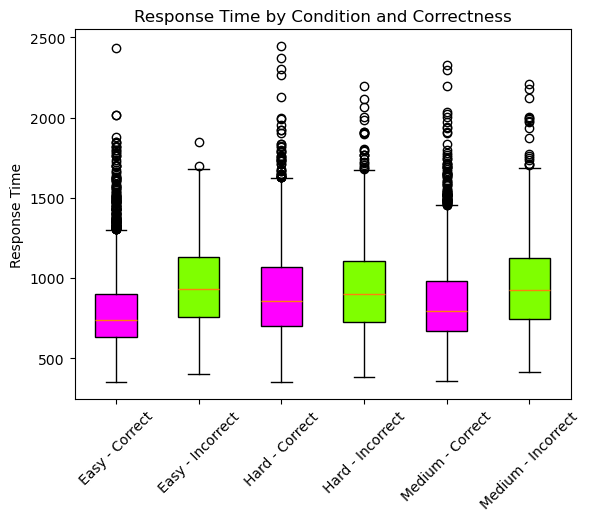

In [20]:

conditions = sorted(data['Condition'].unique())
colors = {1:'magenta', 0:'chartreuse'}
boxplot_data = []
labels = []
for cond in conditions:
    for correct in [1,0]:
        subset = data[(data['Condition']== cond) & (data['Correct'] == correct)]
        boxplot_data.append(subset['ResponseTime'])
        labels.append(f"{cond} - {'Correct' if correct==1 else 'Incorrect'}")
bp = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)    

for patch, label in zip(bp['boxes'], labels):
    if 'Correct' in label:
        patch.set_facecolor(colors[1])
    else:
        patch.set_facecolor(colors[0])

plt.xticks(rotation=45)
plt.ylabel('Response Time')
plt.title('Response Time by Condition and Correctness')
plt.tight_layout
plt.show


d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

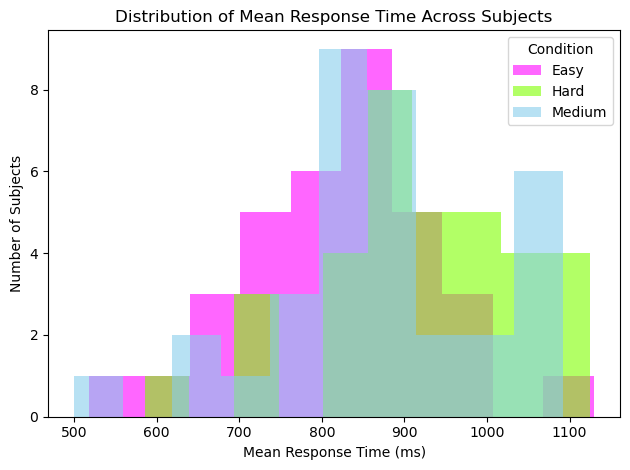

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("ResponseTimeData.csv")
mean_rt = data.groupby(['Subject', 'Condition'])['ResponseTime'].mean().reset_index()
conditions = mean_rt['Condition'].unique()
colors = ['magenta', 'chartreuse', 'skyblue'] 
for cond, color in zip(conditions, colors):
    subset = mean_rt[mean_rt['Condition'] == cond]['ResponseTime']
    plt.hist(subset, bins=10, alpha=0.6, label=cond, color=color)

plt.xlabel('Mean Response Time (ms)')
plt.ylabel('Number of Subjects')
plt.title('Distribution of Mean Response Time Across Subjects')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [2]:
def shiftedwald(params, x):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = ((np.abs(alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f

### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [5]:
import pandas as pd
data = pd.read_csv("ResponseTimeData.csv")
def negloglikeWald(params):
    ''' written with params containing gamma, alpha, theta in that order.  Assumes data is in the variable data'''
    gamma, alpha, theta = params
    x = data - theta
    x = x[x > 0]
    z = alpha / np.sqrt(2 * np.pi * (x ** 3))
    w = ((alpha - gamma * x) ** 2) / (2 * x)
    f = z * np.exp(-w)
    f[f <= 0] = 1e-10
    negloglike = -np.sum(np.log(f))
    return negloglike 

In [11]:
import numpy
import scipy
print(numpy.__version__)
print(scipy.__version__)


2.1.3
1.10.0


### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ReactionTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution. 
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

Model A (all data) parameters:
gamma: 0.0156, alpha: 12.4138, theta: 0.3934

Model B (per condition) parameters:
Medium: gamma=0.0136, alpha=11.1798, theta=0.6632
Hard: gamma=0.0103, alpha=11.4749, theta=0.2100
Easy: gamma=0.0133, alpha=12.2221, theta=0.5871


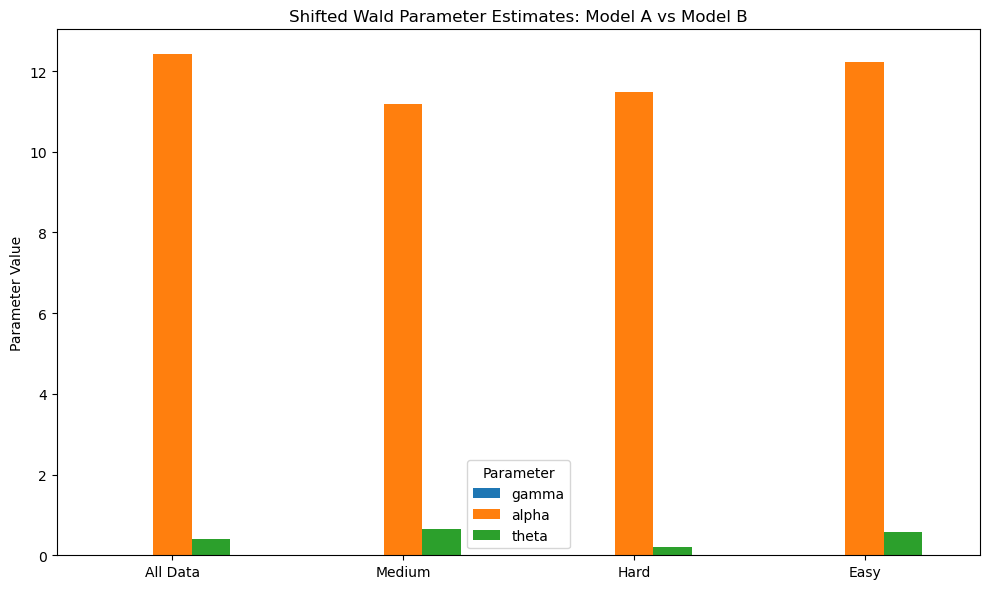

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv("ResponseTimeData.csv")


rt_col = 'ResponseTime'           
cond_col = 'Condition'   

# Negative log-likelihood function 
def negloglikeWald(params, data_subset):
    gamma, alpha, theta = params
    x = data_subset - theta
    x = x[x > 0]
    z = alpha / np.sqrt(2 * np.pi * (x ** 3))
    w = ((alpha - gamma * x) ** 2) / (2 * x)
    f = z * np.exp(-w)
    f[f <= 0] = 1e-10
    return -np.sum(np.log(f))

# Random search optimizer, google gemini had to help me with this part
def fit_shifted_wald(data_subset, n_iter=5000):
    best_params = np.array([0.1, 0.1, 0.01])
    best_nll = negloglikeWald(best_params, data_subset)
    for _ in range(n_iter):
        trial = best_params + np.random.normal(scale=0.05, size=3)
        trial = np.maximum(trial, 1e-6)
        nll = negloglikeWald(trial, data_subset)
        if nll < best_nll:
            best_nll = nll
            best_params = trial
    return best_params, best_nll

# Model A: 
all_data = data[rt_col].values
params_A, nll_A = fit_shifted_wald(all_data)
print("Model A (all data) parameters:")
print(f"gamma: {params_A[0]:.4f}, alpha: {params_A[1]:.4f}, theta: {params_A[2]:.4f}\n")

# Model B: 
conditions = data[cond_col].unique()
params_B = {}
print("Model B (per condition) parameters:")
for cond in conditions:
    subset = data.loc[data[cond_col] == cond, rt_col].values
    params, nll = fit_shifted_wald(subset)
    params_B[cond] = params
    print(f"{cond}: gamma={params[0]:.4f}, alpha={params[1]:.4f}, theta={params[2]:.4f}")

# Model A and B for plotting 
# Model A as a column
df_A = pd.DataFrame(params_A, index=["gamma", "alpha", "theta"], columns=["All Data"])
# Model B as columns
df_B = pd.DataFrame(params_B, index=["gamma", "alpha", "theta"])
# Concatenate for plotting
df_plot = pd.concat([df_A, df_B], axis=1)

# Plot
df_plot.T.plot(kind='bar', figsize=(10,6))
plt.title("Shifted Wald Parameter Estimates: Model A vs Model B")
plt.ylabel("Parameter Value")
plt.xticks(rotation=0)
plt.legend(title="Parameter")
plt.tight_layout()
plt.show()

#i tried to use scipy but i kept getting errors with my computer system, and couldn't fix it, so i just wrote the code a different way with the help of google gemini. i will try to get the scipy issue fixed asap.



### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

In [12]:
import pandas as pd
import numpy as np


data = pd.read_csv("ResponseTimeData.csv")
values = data['ResponseTime'].values  
conditions = data["Condition"].unique()


def log_likelihood_normal(x):
    n = len(x)
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)
    ll = -0.5*n*np.log(2*np.pi) - n*np.log(sigma) - np.sum((x - mu)**2)/(2*sigma**2)
    return ll, mu, sigma

ll1, mu1, sigma1 = log_likelihood_normal(values)
k_A = 2  # mu and sigma
AIC_A = 2*k1 - 2*ll1
print("AIC Model A (1 distribution):", AIC1)



conditions = data['Condition'].unique()
ll_B = 0
k_B = 0

for cond in conditions:
    subset = data[data['Condition'] == cond]['ResponseTime'].values
    ll, mu, sigma = log_likelihood_normal(subset)
    ll_B += ll
    k_B += 2  # mu and sigma for each condition

AIC_B = 2*k_B - 2*ll_B
print("AIC Model B (3 distributions):", AIC_B)

if AIC_A < AIC_B:
    print("Model A preferred → data likely come from 1 distribution")
else:
    print("Model B preferred → data likely come from separate distributions for each condition")


AIC Model A (1 distribution): 162578.37849447125
AIC Model B (3 distributions): 162218.24084580995
Model B preferred → data likely come from separate distributions for each condition


### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions. 

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

In [ ]:
import pandas as pd
import numpy as np


data = pd.read_csv("ResponseTimeData.csv")
rt = data['ResponseTime'].values
condition = data['Condition'].values


def ddm_pdf(rt, alpha, theta, gamma):
    t = rt - theta
    t = np.maximum(t, 1e-6)  
    
    
    mu = alpha / gamma
    sigma = alpha / 4  
    ll = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(t - mu)**2 / (2 * sigma**2))
    return ll

# Step 2: Negative log-likelihood function 
def nll_ddm(params, rt, condition):
    gamma_easy, gamma_medium, gamma_hard, alpha, theta = params
    nll = 0
    for r, cond in zip(rt, condition):
        # Select the correct gamma for each condition
        if cond == 'Easy':
            gamma = gamma_easy
        elif cond == 'Medium':
            gamma = gamma_medium
        elif cond == 'Hard':
            gamma = gamma_hard
        else:
            raise ValueError(f"Unknown condition: {cond}")
        
        # Compute likelihood for this trial
        likelihood = ddm_pdf(r, alpha, theta, gamma)
        likelihood = max(likelihood, 1e-12)  # avoid log(0)
        nll -= np.log(likelihood)
    return nll


example_params = [0.5, 0.6, 0.7, 1.2, 0.3]  # gamma_easy, gamma_medium, gamma_hard, alpha, theta
nll_value = nll_ddm(example_params, rt, condition)
print("Negative log-likelihood:", nll_value)


Negative log-likelihood: 320077.7486069202


### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

In [ ]:
rt = data['ResponseTime'].values
condition = data['Condition'].values
def ddm_pdf(rt, alpha, theta, gamma):
    """
    Simplified likelihood for demonstration.
    rt: response time
    alpha: boundary separation (shared)
    theta: non-decision time (shared)
    gamma: drift rate (per condition)
    """
    t = rt - theta
    t = np.maximum(t, 1e-6)
    mu = alpha / gamma
    sigma = alpha / 4
    ll = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(t - mu)**2 / (2 * sigma**2))
    return ll

def nll_ddm(params, rt, condition):
    gamma_easy, gamma_medium, gamma_hard, alpha, theta = params
    nll = 0
    for r, cond in zip(rt, condition):
        if cond == 'Easy':
            gamma = gamma_easy
        elif cond == 'Medium':
            gamma = gamma_medium
        elif cond == 'Hard':
            gamma = gamma_hard
        else:
            raise ValueError(f"Unknown condition: {cond}")
        likelihood = ddm_pdf(r, alpha, theta, gamma)
        likelihood = max(likelihood, 1e-12)
        nll -= np.log(likelihood)
    return nll

starting_params = [1.0, 0.7, 0.4, 1.0, 0.3]  # [gamma_easy, gamma_medium, gamma_hard, alpha, theta]


nll_value = nll_ddm(starting_params, rt, condition)
print("Negative log-likelihood (Model C, starting guess):", nll_value)

k_C = 5  
AIC_C = 2 * k_C + 2 * nll_value
print("AIC Model C:", AIC_C)


AIC_A = 162578.378
AIC_B = 162218.241

table = pd.DataFrame({
    "Model": ["A (1 dist)", "B (3 cond dists)", "C (drift varies)"],
    "Parameters": [2, 6, 5],
    "AIC": [AIC_A, AIC_B, AIC_C],
    "Notes": ["Single distribution",
              "Separate by condition",
              "Alpha & theta shared, gamma varies"]
})

# Sort by AIC (lowest = best)
table = table.sort_values("AIC").reset_index(drop=True)
print(table)


Negative log-likelihood (Model C, starting guess): 320077.7486069202
AIC Model C: 640165.4972138404
              Model  Parameters            AIC  \
0  B (3 cond dists)           6  162218.241000   
1        A (1 dist)           2  162578.378000   
2  C (drift varies)           5  640165.497214   

                                Notes  
0               Separate by condition  
1                 Single distribution  
2  Alpha & theta shared, gamma varies  


### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   